In [1]:
# REQUIREMENTS.TXT

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')


In [2]:
import pandas as pd
stations = pd.read_csv("./datasets/station_service_stations.csv",sep=';',encoding="utf-8")

# FIX ENCODING
stations=stations.replace({'Ã¼': 'ü','\'':''}, regex=True) # ü
stations=stations.replace({'ÃŸ': 'ß','\'':''}, regex=True) # ß
stations=stations.replace({'Ã¶': 'ö','\'':''}, regex=True) # ö
stations=stations.replace({'Ã¶': 'ö','\'':''}, regex=True) # ß
# PRINT RAW RESULT
stations.head(5)

,EVA_NR,DS100,IFOPT,NAME,Verkehr,Laenge,Breite,Betreiber_Name,Betreiber_Nr,Status
0,8002551,AELB,de:02000:11943,Hamburg Elbbrücken,RV,"10,0245","53,5345",DB Station und Service AG,NaN,neu
1,8001944,TETN,NaN,Eutingen Nord,RV,"8,7531","48,4847",DB Station und Service AG,NaN,neu
2,8003074,MIA,NaN,Ingolstadt Audi,RV,"11,4074564","48,7904959",DB Station und Service AG,NaN,neu
3,8001723,HEBA,NaN,Einbeck Otto-Hahn-Straße,RV,"9,89290953","51,8144784",Ilmebahn GmbH,NaN,neu
4,8004371,KRO,NaN,Nörvenich-Rommelsheim,nur DPN,"6,547586","50,782539",Rurtalbahn GmbH,NaN,neu


In [3]:
# FILTER STATIONS
# 1. RV = REGIONALVERKEHR
# 2. NUR HAUPTBAHNHÖFE
BN_TYPE = "DB Station und Service AG" # DB Station und Service AG 

stations_filtered = stations[(stations['Verkehr'] == "RV" )]
stations_filtered = stations_filtered[(stations_filtered['Betreiber_Name'] == BN_TYPE )]
stations_filtered

,EVA_NR,DS100,IFOPT,NAME,Verkehr,Laenge,Breite,Betreiber_Name,Betreiber_Nr,Status
0,8002551,AELB,de:02000:11943,Hamburg Elbbrücken,RV,"10,0245","53,5345",DB Station und Service AG,NaN,neu
1,8001944,TETN,NaN,Eutingen Nord,RV,"8,7531","48,4847",DB Station und Service AG,NaN,neu
2,8003074,MIA,NaN,Ingolstadt Audi,RV,"11,4074564","48,7904959",DB Station und Service AG,NaN,neu
6,8001510,TDSA,de:08237:8009:2,Dornstetten-Aach,RV,"8,48291","48,4733",DB Station und Service AG,NaN,neu
8,8002060,FFGG,de:06412:11500,Frankfurt(Main)-Gateway Gardens,RV,"8,59449506","50,0565739",DB Station und Service AG,NaN,neu
...,...,...,...,...,...,...,...,...,...,...
6358,8098493,NND,de:09564:407,Nürnberg Frankenstadion Sonderbahnsteig,RV,"11,127479","49,431761",DB Station und Service AG,4598.0,NaN
6360,8005777,TSZAH,de:08111:1200,Stuttgart-Zazenhausen,RV,"9,199539","48,836034",DB Station und Service AG,6089.0,NaN
6361,8005771,TSM,de:08111:1504,Stuttgart-Münster,RV,"9,21586","48,820724",DB Station und Service AG,6080.0,NaN
6362,8005766,TSEB,de:08111:1604,Stuttgart Ebitzweg,RV,"9,231701","48,803938",DB Station und Service AG,6070.0,NaN


In [4]:
# SIMPLYFY DATA AND REMOVE COLUMNS
stations_filtered = stations_filtered[['EVA_NR', 'NAME', 'Laenge', 'Breite']]
stations_filtered.head(5)

,EVA_NR,NAME,Laenge,Breite
0,8002551,Hamburg Elbbrücken,"10,0245","53,5345"
1,8001944,Eutingen Nord,"8,7531","48,4847"
2,8003074,Ingolstadt Audi,"11,4074564","48,7904959"
6,8001510,Dornstetten-Aach,"8,48291","48,4733"
8,8002060,Frankfurt(Main)-Gateway Gardens,"8,59449506","50,0565739"


In [5]:
# NOW WE HAVE CLEANED STATION DATA WITH LAT AND LONG INFOMRATION ABOUT EACH STATION FROM DB
# THE NEXT STEP IS TO MATCH THE STATIONS WITH THE LANDKREISE OF THE RKI
# TO MAP THE SIMULATED RESULTS WITH THE CORONA DATA

In [6]:
import geopandas as gpd
landkreis_geo = gpd.read_file("./datasets/RKI_Corona_Landkreise.geojson")
landkreis_geo.head(5)

,OBJECTID,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,...,recovered,EWZ_BL,cases7_bl_per_100k,cases7_bl,death7_bl,cases7_lk,death7_lk,cases7_per_100k_txt,AdmUnitId,geometry
0,1,4.0,4.0,1.0,01001,01001,010010000000,Flensburg,Kreisfreie Stadt,40.0,...,None,2910875,150.195388,4372,3,115,1,"127,9",1001,"POLYGON ((9.41266 54.82264, 9.41318 54.82124, ..."
1,2,4.0,4.0,1.0,01002,01002,010020000000,Kiel,Kreisfreie Stadt,40.0,...,None,2910875,150.195388,4372,3,319,0,"129,4",1002,"POLYGON ((10.16916 54.43138, 10.16957 54.43067..."
2,3,4.0,4.0,1.0,01003,01003,010030000000,Lübeck,Kreisfreie Stadt,40.0,...,None,2910875,150.195388,4372,3,428,0,"198,3",1003,"POLYGON ((10.87683 53.98737, 10.87884 53.98595..."
3,4,4.0,4.0,1.0,01004,01004,010040000000,Neumünster,Kreisfreie Stadt,40.0,...,None,2910875,150.195388,4372,3,125,0,"156,4",1004,"POLYGON ((9.99545 54.14972, 9.99713 54.14806, ..."
4,5,4.0,4.0,1.0,01051,01051,010510044044,Dithmarschen,Kreis,42.0,...,None,2910875,150.195388,4372,3,122,0,"91,6",1051,"MULTIPOLYGON (((8.69258 54.06045, 8.69364 54.0..."


<GeoAxesSubplot:>

/opt/conda/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/conda/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/conda/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


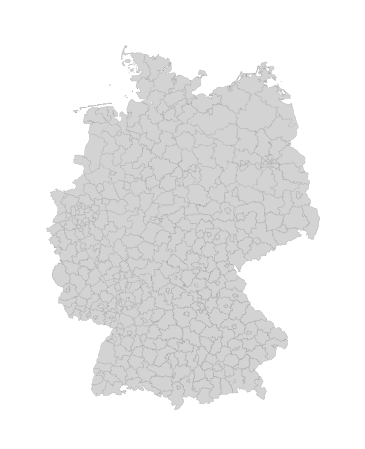

In [7]:
import geoplot
import geoplot.crs as gcrs
# PLOT LOADED GEOJSON DATA
geoplot.polyplot(landkreis_geo, projection=gcrs.AlbersEqualArea(), edgecolor='darkgrey', facecolor='lightgrey', linewidth=.3, figsize=(12, 8))

In [8]:
# AS WE CAN SEE IN THE RENDERED GEOJSON, THE FILE CONTAINS POLYGONS OF EACH LANDKREIS
# SO THE NEXT STEP IS TO MATCH THE LANDKREIS POLYGON WITH THE LAT AND LONG OF THE DB STATION DATA
gpd_points_lat = []
gpd_points_long = []

for index, row in stations_filtered.iterrows():
    # BUT FIRST WE NEED TO FIX THE , FLOARINGPOINT GERMAN STUFF...
    lat = float(str(row['Breite']).replace(',','.'))
    long = float(str(row['Laenge']).replace(',','.'))
    # !!!!!! SWITCH LAT LONG !!!!!!!!!!!!
    gpd_points_lat.append(long)
    gpd_points_long.append(lat)

gpd_points = gpd.points_from_xy(gpd_points_lat, gpd_points_long)

stations_geo_preperation = stations_filtered[['EVA_NR', 'NAME']]

station_geo_points = gpd.GeoDataFrame(stations_geo_preperation, geometry=gpd_points, crs="EPSG:4326")
station_geo_points.head(5)

,EVA_NR,NAME,geometry
0,8002551,Hamburg Elbbrücken,POINT (10.02450 53.53450)
1,8001944,Eutingen Nord,POINT (8.75310 48.48470)
2,8003074,Ingolstadt Audi,POINT (11.40746 48.79050)
6,8001510,Dornstetten-Aach,POINT (8.48291 48.47330)
8,8002060,Frankfurt(Main)-Gateway Gardens,POINT (8.59450 50.05657)


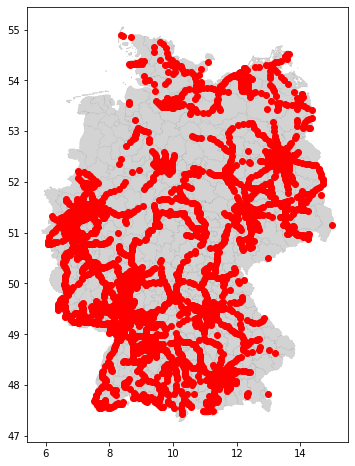

In [9]:
# VISULIZE THE STATIONS INSIDE THE GEOJSON MAP
import matplotlib.pyplot as plt
# USE THE LANFKREIS GEO DATA AS BASE WITH THE SAME SETTINGS
lkg_plot = landkreis_geo.plot(edgecolor='darkgrey', facecolor='lightgrey', linewidth=.2, figsize=(12, 8))
# DRAW THE STATION POINTS OVER
station_geo_points.plot(ax=lkg_plot, color='red')
plt.show(lkg_plot)


In [10]:
# THE LAST STEP IS TO PERFORM A TEST WHICH LANDKREISID CONTAINS WHICH STATIONS
# SO THE RESULT SHOULD BE A STATION + RKI LANKREIS DATA DATAFRAME

In [11]:
# community = landkreis_geo #landkreis_geo[landkreis_geo.GEN == 'Flensburg'] # TEST
station_geo_lkid = gpd.sjoin(landkreis_geo,station_geo_points)
station_geo_lkid.head(5)
len(station_geo_lkid)

3435

In [12]:
# NOW WE HAVE A 5000x 51 sized dataframe
# IN THIS STAGE WE DONT NEED ONLY THE LANDKREISID AND THE STATION ID + GEOINFORMATION
# SO LETS STRIP IT DOWN
station_geo_lkid = station_geo_lkid[['NAME','GEN','BEZ','geometry','EVA_NR', 'AGS']]
station_geo_lkid.columns = ['db_station_name', 'rki_landkreisname', 'rki_bezeichner','geometry', 'db_station_id','rki_ags']
station_geo_lkid.head(5)

# FINALLY FILTER FOR SOME 

,db_station_name,rki_landkreisname,rki_bezeichner,geometry,db_station_id,rki_ags
1,Kiel-Elmschenhagen,Kiel,Kreisfreie Stadt,"POLYGON ((10.16916 54.43138, 10.16957 54.43067...",8003477,01002
1,Kiel-Russee,Kiel,Kreisfreie Stadt,"POLYGON ((10.16916 54.43138, 10.16957 54.43067...",8003253,01002
1,Kiel-Hassee CITTI-PARK,Kiel,Kreisfreie Stadt,"POLYGON ((10.16916 54.43138, 10.16957 54.43067...",8003474,01002
1,Suchsdorf,Kiel,Kreisfreie Stadt,"POLYGON ((10.16916 54.43138, 10.16957 54.43067...",8005781,01002
2,Lübeck Flughafen,Lübeck,Kreisfreie Stadt,"POLYGON ((10.87683 53.98737, 10.87884 53.98595...",8003781,01003


In [13]:
# KEEP ONLY ONE TRAIN STATION FOR EACH COMMUNITY
station_geo_lkid = station_geo_lkid.sort_values('db_station_id').drop_duplicates(subset=['rki_ags'], keep='last')

# DROP NAN ROWS
station_geo_lkid.dropna(inplace=True)
station_geo_lkid.head(5)

,db_station_name,rki_landkreisname,rki_bezeichner,geometry,db_station_id,rki_ags
268,Bayreuth Hbf,Bayreuth,Kreisfreie Stadt,"MULTIPOLYGON (((11.49479 49.96313, 11.49366 49...",8000028,09462
97,Brackwede,Bielefeld,Kreisfreie Stadt,"POLYGON ((8.50936 52.11483, 8.51095 52.11349, ...",8000048,05711
235,Kaufering,Landsberg am Lech,Landkreis,"POLYGON ((10.90985 48.23618, 10.91087 48.23606...",8000195,09181
259,Weiden(Oberpf),Weiden i.d. OPf.,Kreisfreie Stadt,"POLYGON ((12.13912 49.70958, 12.14361 49.70795...",8000204,09363
245,Landshut(Bay)Hbf,Landshut,Kreisfreie Stadt,"POLYGON ((12.28209 48.59062, 12.28221 48.59054...",8000217,09261


In [14]:
# GENERATE A SMALLER DATASET WITHOUT THE GEOMETY
station_geo_lkid_wo_geometry = station_geo_lkid[['db_station_name', 'rki_landkreisname', 'rki_bezeichner', 'db_station_id', 'rki_ags']]
station_geo_lkid_wo_geometry.head(5)

,db_station_name,rki_landkreisname,rki_bezeichner,db_station_id,rki_ags
268,Bayreuth Hbf,Bayreuth,Kreisfreie Stadt,8000028,09462
97,Brackwede,Bielefeld,Kreisfreie Stadt,8000048,05711
235,Kaufering,Landsberg am Lech,Landkreis,8000195,09181
259,Weiden(Oberpf),Weiden i.d. OPf.,Kreisfreie Stadt,8000204,09363
245,Landshut(Bay)Hbf,Landshut,Kreisfreie Stadt,8000217,09261


In [15]:
# TO SIMPLYFY THINGS THE ONLY GOING TO USE ONLY "MAIN" STATION WITH THE Hbf SUBSTRING

station_geo_lkid_wo_geometry_hbf = station_geo_lkid_wo_geometry[station_geo_lkid_wo_geometry['db_station_name'].str.contains('Hbf')]
# REMOVE S-BAHN STATION (S-Bahn) WITH ~ OPERATOR
station_geo_lkid_wo_geometry_hbf = station_geo_lkid_wo_geometry_hbf[~station_geo_lkid_wo_geometry_hbf['db_station_name'].str.contains('(S-Bahn)')]
station_geo_lkid_wo_geometry_hbf.head(5)

,db_station_name,rki_landkreisname,rki_bezeichner,db_station_id,rki_ags
268,Bayreuth Hbf,Bayreuth,Kreisfreie Stadt,8000028,09462
245,Landshut(Bay)Hbf,Landshut,Kreisfreie Stadt,8000217,09261
270,Hof Hbf,Hof,Kreisfreie Stadt,8002924,09464
164,Pirmasens Hbf,Pirmasens,Kreisfreie Stadt,8004822,07317
165,Speyer Hbf,Speyer,Kreisfreie Stadt,8005628,07318


In [16]:
# FINALLY SAVE THE PREPARED DATA
station_geo_lkid.to_file("./generated/0_db_station_rki_lk.geojson", driver='GeoJSON')
station_geo_lkid.to_file("./generated/0_db_station_rki_lk.gpkg", layer='world', driver="GPKG")
station_geo_lkid_wo_geometry.to_csv("./generated/0_db_station_lk.csv", encoding='utf-8', index=False, sep=';')
station_geo_lkid_wo_geometry_hbf.to_csv("./generated/0_db_station_lk_hbf.csv", encoding='utf-8', index=False, sep=';')

In [17]:
# SAVE FILES FOR VISUALISATION

station_geo_lkid.to_file("./generated/visualisation_files/staions_landkreis.geojson", driver='GeoJSON')
landkreis_geo.to_file("./generated/visualisation_files/landkreis.geojson", driver='GeoJSON')
